## Burst Analysis Workflow - AI
- Input:
    * WoS_[area].csv Wos_id|Keywords|Year...
    * NSF_[area].csv ID|Year|Abstracts|Title...


In [ ]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import pylab as plt
import math
from os import listdir
import random
import time
import matplotlib.cm as cm
from numpy.random import choice
import itertools
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
import re
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from matplotlib.ticker import MaxNLocator

In [ ]:
area='ai'

### Step 1 Normalize keywords in OpenRefine (see documentation) (https://openrefine.org/)
### Step 2 Run Burst Analysis in Sci2 (https://sci2.cns.iu.edu/user/index.php)
- input: 
    * [area]\_wos_keywords.csv
    * [area]\_nsf_keywords.csv
- get output:
    * [area]\_wos_input.csv
    * [area]\_nsf_input.csv

### Step 3 Get Burst from NSF and WOS

##### 1) Load data generated from Sci2

In [ ]:
wos_burst_path='data/sci2-ai-wos-output.csv'
nsf_burst_path='data/sci2-ai-nsf-output.csv'
WOSkw = pd.read_csv(wos_burst_path)
NSFkw = pd.read_csv(nsf_burst_path)
NSFkw['Word'] = NSFkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.lower() 

In [ ]:
### Merge two sets
WOSkw['Word'] = WOSkw['Word'].str.title() 
WOSkw['cat'] = 'wos'
NSFkw['Word'] = NSFkw['Word'].str.title() 
NSFkw['cat'] = 'nsf'
nsfwosai = pd.concat([WOSkw, NSFkw], ignore_index=True)

In [ ]:
print('Total WOS AI bursts:', len(WOSkw))
print('Total NSF AI bursts:', len(NSFkw))

Total WOS AI bursts: 89
Total NSF AI bursts: 161


##### 2) Sort busrst

In [ ]:
#Top Bursts
print('nsf-max',max(NSFkw.Weight),NSFkw.loc[NSFkw.Weight==max(NSFkw.Weight),'Word'].values[0])
print('wos-max',max(WOSkw.Weight),WOSkw.loc[WOSkw.Weight==max(WOSkw.Weight),'Word'].values[0])
print('nsf-min',min(NSFkw.Weight),NSFkw.loc[NSFkw.Weight==min(NSFkw.Weight),'Word'].values[0])
print('wos-min',min(WOSkw.Weight),WOSkw.loc[WOSkw.Weight==min(WOSkw.Weight),'Word'].values[0])

nsf-max 13.04195439 Machine Learning
wos-max 39.29231663 Learning (Artificial Intelligence)
nsf-min 3.0454774710000003 Pc
wos-min 3.0513137410000004 Genetic Algorithm (Ga)


##### 3) Find Double Bursts 

In [ ]:
# WOS Double Burst
# Select all duplicate terms based on Word column
WOSkw[WOSkw.duplicated(['Word'], keep=False)]

Empty DataFrame
Columns: [Word, Level, Weight, Length, Start, End, cat]
Index: []

In [ ]:
#NSF Double Burst
NSFkw[NSFkw.duplicated(['Word'], keep=False)]

Empty DataFrame
Columns: [Word, Level, Weight, Length, Start, End, cat]
Index: []

In [ ]:
# Select all duplicate terms based on Word column
duplicates = nsfwosai[nsfwosai.duplicated(['Word'], keep=False)]
duplicates.sort_values(['Word'])

Word  Level     Weight  Length  Start   End  cat
0              Agents      1   8.517200       2   1998  1999  wos
131            Agents      1   3.251759      10   1999  2008  nsf
68           Big Data      1  16.168361       3   2015  2017  wos
232          Big Data      1   8.972520       5   2013  2017  nsf
65          Component      1   3.452716       3   2013  2015  wos
102         Component      1   4.182642       7   1998  2004  nsf
8             Control      1   5.714375       5   1998  2002  wos
99            Control      1   3.436222       1   2003  2003  nsf
72      Deep Learning      1  18.487784       2   2016  2017  wos
215     Deep Learning      1   7.049418       4   2014  2017  nsf
25     Expert Systems      1  17.988222       9   1998  2006  wos
95     Expert Systems      1   3.371153       6   1998  2003  nsf
79   Machine Learning      1  26.411891       1   2017  2017  wos
191  Machine Learning      1  13.041954       3   2015  2017  nsf
46         Psychology      1   3.381516       7   2003  2009  wos
157        Psychology      1   3.606917       2   2012  2013  nsf

##### 4) Identify Top 10 for WOS and NSF

In [ ]:
wos_top={}

# sum weight and pick top15
for i in WOSkw.index:
    word=WOSkw['Word'][i].lower()
    weight=WOSkw['Weight'][i]
    start=WOSkw['Start'][i]
    end=WOSkw['End'][i]
    if word in wos_top:
        wos_top[word][0]+=weight
        if start<wos_top[word][1]:
            wos_top[word][1]=start
            wos_top[word][2]=end 
    else:
        wos_top[word]=[weight,start,end]

wos_df=pd.DataFrame.from_dict(wos_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

wos_topdf=wos_df.sort_values(ascending=[False],by=['sum_weight'])[0:9] # change from 10 

for i in WOSkw.index:
    if WOSkw['Word'][i].lower() not in wos_topdf.index:
        WOSkw=WOSkw.drop([i])
WOSkw=WOSkw.reset_index(drop=True)        
WOSkw['Word']=[i.lower() for i in list(WOSkw['Word'])]

In [ ]:
nsf_top={}

# sum weight and pick top15
for i in NSFkw.index:
    word=NSFkw['Word'][i].lower()
    weight=NSFkw['Weight'][i]
    start=NSFkw['Start'][i]
    end=NSFkw['End'][i]
    if word in nsf_top:
        nsf_top[word][0]+=weight
        if start<nsf_top[word][1]:
            nsf_top[word][1]=start
            nsf_top[word][2]=end        
    else:
        nsf_top[word]=[weight,start,end]

nsf_df=pd.DataFrame.from_dict(nsf_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

nsf_topdf=nsf_df.sort_values(ascending=[False],by=['sum_weight'])[0:9]  

#nsf_topdf=nsf_topdf.sort_values(ascending=[True,False],by=['first_start','sum_weight']) 

#NSFkw.loc[]

for i in NSFkw.index:
    if NSFkw['Word'][i].lower() not in nsf_topdf.index:
        NSFkw=NSFkw.drop([i])
NSFkw=NSFkw.reset_index(drop=True)     
NSFkw['Word']=[i.lower() for i in list(NSFkw['Word'])]

In [ ]:
allkw_list=pd.concat([nsf_topdf,wos_topdf])
allkw_list=allkw_list.sort_values(ascending=[True,True,False],by=['first_start','end','sum_weight'])
allkw_list=allkw_list.reset_index()

##### 5) Find Overlap between NSF and WOS

In [ ]:
overlap=allkw_list[list(allkw_list['index'].duplicated()==True)]
allkw_list=allkw_list[list(allkw_list['index'].duplicated()!=True)] #remove duplicated
allkw_list=allkw_list.reset_index()

In [ ]:
overlap_list=pd.DataFrame(columns=['Word','Length','Weight','Start','End'])
for i in range(len(overlap)):
    print(overlap['index'].values[i]+'-NSF: ')
    print(len(NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]))
    print(overlap['index'].values[i]+'-WOS: ')
    print(len(WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]))
    nsf_ol=NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]
    wos_ol=WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]
    nsf_ol=nsf_ol.reset_index()
    wos_ol=wos_ol.reset_index()
    for k in range(len(nsf_ol)):
        for j in range(len(wos_ol)):
            Word=nsf_ol.loc[k,'Word']
            Level=1
            Weight=max(nsf_ol.loc[k,'Weight'],wos_ol.loc[j,'Weight'])
            max_Start=max(nsf_ol.loc[k,'Start'],wos_ol.loc[j,'Start'])
            min_End=min(nsf_ol.loc[k,'End'],wos_ol.loc[j,'End'])
            if max_Start<=min_End: ##has overlapped year 
                overlap_list.loc[len(overlap_list),['Word','Weight','Start','End']]=[Word,Weight,max_Start,min_End]
                overlap_list.loc[len(overlap_list)-1,['Length']]=[min_End-max_Start+1]
        


big data-NSF: 
1
big data-WOS: 
1
deep learning-NSF: 
1
deep learning-WOS: 
1
machine learning-NSF: 
1
machine learning-WOS: 
1


In [ ]:
overlap_list

Word Length   Weight Start   End
0          big data      3  16.1684  2015  2017
1     deep learning      2  18.4878  2016  2017
2  machine learning      1  26.4119  2017  2017

In [ ]:
WOSkw['Word'] = WOSkw['Word'].str.title() 
NSFkw['Word'] = NSFkw['Word'].str.title() 
overlap_list['Word'] = overlap_list['Word'].str.title()
allkw_list['index'] = allkw_list['index'].str.title()

In [ ]:
allkw_list.to_csv("top-15-ai.csv", index=False)

### Step 4 Plot Graph

In [ ]:
wos = pd.read_csv('data/wos-three-domains-total-1998-2017.csv', encoding='latin1', sep=",")
nsf = pd.read_csv('data/nsf-three-domains-total-1998-2017.csv', encoding='latin1', sep=",")

##### Final Figures

In [ ]:
Blue NSF - #0D47A1 

Orange Pub -  #EF6C00 

Grey - bdbdbd 

Height - 

Width – 3.5 inch 

Font  Size >=8in 

Font - Arial 

No legend

vertical line - #e0e0e0

In [ ]:
w, h = plt.figaspect(1.618)
fig = plt.figure(figsize=(w, h),facecolor='white')

<Figure size 288x465.984 with 0 Axes>

In [ ]:
plt.rcParams['axes.xmargin'] = 0 # remove whote margins
plt.rcParams['svg.fonttype'] = 'none' # for svg formatting
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 
plt.rcParams['font.sans-serif'] = "Arial"

plt.rcParams['font.family'] = "sans-serif"

np.seterr(divide='ignore', invalid='ignore') # to remove warning messages

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

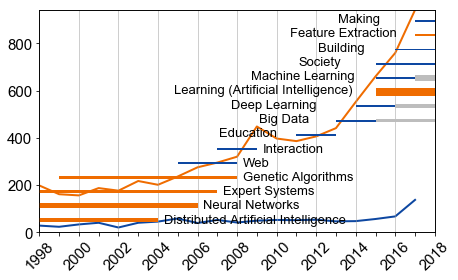

In [ ]:
plt.rcParams['svg.fonttype'] = 'none' # for svg formatting
np.seterr(divide='ignore', invalid='ignore') # to remove warning messages
plt.rc('xtick', labelsize=15) # change size of labels
plt.rc('ytick', labelsize=15) # change size of labels
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
w, h = plt.figaspect(1.618)
fig = plt.figure(figsize=(h, w),facecolor='white')
ax1 = fig.add_subplot(111)

x = [1998, 1999, 2000,2001,2002,2003, 2004,2005, 2006, 2007, 2008, 2009,2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,2018]

ax1.set_ylim(0, max(max(wos.AI.values),max(nsf.AI.values))) # adjust ylim
ax1.set_xlim((1998, 2018))

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.axes.set_xticklabels(x) 
ax1.set_xticklabels(x, rotation=45)

max_weight = 62.16

ax1.plot(wos.year.values,wos.AI.values, linewidth = 2, color="#EF6C00")  # orange wos
ax1.plot(wos.year.values,nsf.AI.values,linewidth = 2,color = "#0D47A1")  # blue nsf

ax1.grid(b=False) # turn off grid #2
plt.axvline(x=2000, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2002, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2004, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2006, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2008, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2010, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2012, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2014, color='#9e9e9e',linewidth = 0.5)
plt.axvline(x=2016, color='#9e9e9e',linewidth = 0.5)
my_yticks=allkw_list['index']  

ax2 = ax1.twinx()  # set up the 2nd axis

for x in range(0,len(WOSkw)):
    color="#EF6C00" #orange -- wos
    i=allkw_list.index[allkw_list['index']==WOSkw['Word'][x]].values[0]

    ax2.barh([i], left=WOSkw.iloc[x].Start, width=WOSkw.iloc[x].End-WOSkw.iloc[x].Start+1, color=color,height=WOSkw.iloc[x].Weight/max_weight*0.8+0.03,alpha=1)
 
  
for x in range(0,len(NSFkw)):
    color="#0D47A1" #blue -- nsf
    i=allkw_list.index[allkw_list['index']==NSFkw['Word'][x]].values[0]
    
    ax2.barh([i], left=NSFkw.iloc[x].Start, width=NSFkw.iloc[x].Length,  color=color,height=NSFkw[x:(x+1)].Weight/max_weight*0.8+0.03,alpha=1)

    
for x in range(0,len(overlap_list)):
    color="#bdbdbd" #grey -- nsf  grey
    i=allkw_list.index[allkw_list['index']==overlap_list['Word'][x]].values[0]
    
    ax2.barh([i], width=overlap_list[x:(x+1)].Length, left=overlap_list[x:(x+1)].Start, color=color,height=overlap_list[x:(x+1)].Weight/max_weight*0.8+0.03,alpha=1)


for x in range(0,6):
        ax2.text(float(allkw_list[x:(x+1)].end+1.3), float(x-0.2) , allkw_list['index'][x], fontname='Arial',size=13)# addd values to bars


for x in range(6,15):
    if len(allkw_list['index'][x]) < 12: 
        ax2.text(float(allkw_list[x:(x+1)].first_start-3.9), float(x-0.1) , allkw_list['index'][x], fontname='Arial',size=13)# addd values to bars
    if len(allkw_list['index'][x]) >= 12 and len(allkw_list['index'][x]) < 21:
        ax2.text(float(allkw_list[x:(x+1)].first_start-6.3), float(x-0.1) , allkw_list['index'][x], fontname='Arial',size=13)#
    if len(allkw_list['index'][x]) >= 21:
        ax2.text(float(allkw_list[x:(x+1)].first_start-10.2), float(x-0.1) , allkw_list['index'][x], fontname='Arial',size=13)#


ax2 = plt.gca()  

ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xticks([1998, 1999, 2000,2001,2002,2003, 2004,2005, 2006, 2007, 2008, 2009,2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,2018])

ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_yticklabels([])

plt.xticks(rotation=45)
ax1.tick_params(axis=u'x', which=u'x',length=4)
plt.setp(ax1.get_xticklabels()[1::2], visible=False)

fig.tight_layout()

plt.savefig('Fig-burst-ai.svg')
plt.savefig('Fig-burst-ai.png')
plt.show()